In [55]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [3]:
num_classes = len(emotion_labels)


In [4]:
fer_data = h5py.File('C:/Users/Student/Desktop/Facial_Emotion_Detection/FER-2013/data.h5', 'r', driver='core')

In [5]:
fer_x = np.asarray(fer_data['Training_pixel']).reshape((28709, 48*48))

In [6]:
fer_y = fer_data['Training_label']
print(fer_y)

<HDF5 dataset "Training_label": shape (28709,), type "<i8">


In [7]:
X_train = fer_x

In [8]:
X_test_public=np.asarray(fer_data['PublicTest_pixel']).reshape((3589,48*48))
print(X_test_public)

[[254 254 254 ...  42 129 180]
 [156 184 198 ... 172 167 161]
 [ 69 118  61 ...  88  87  90]
 ...
 [255 255 255 ...  48  50  46]
 [ 33  25  31 ...   4   5   4]
 [ 61  63  59 ... 113 165 180]]


In [9]:
X_test_private=np.asarray(fer_data['PrivateTest_pixel']).reshape((3589,48*48))

In [10]:
num_train = X_train.shape[0]

In [11]:
num_val_public=X_test_public.shape[0]

In [12]:
num_val_private=X_test_private.shape[0]

In [13]:
print('Training: ',X_train.shape)

Training:  (28709, 2304)


In [14]:
print('PublicTest:',X_test_public.shape)

PublicTest: (3589, 2304)


In [15]:
print('PrivateTest:',X_test_private.shape)

PrivateTest: (3589, 2304)


In [16]:
Y_train = fer_data['Training_label']

In [17]:
Y_train = to_categorical(Y_train, num_classes)

In [18]:
Y_test_public=fer_data['PublicTest_label']

In [19]:
Y_test_private=fer_data['PrivateTest_label']

In [20]:
Y_test_public=to_categorical(Y_test_public,num_classes)

In [21]:
Y_test_private=to_categorical(Y_test_private,num_classes)

In [22]:
print('Training:',Y_train.shape)

Training: (28709, 7)


In [23]:
print('PublicTest:',Y_test_public.shape)

PublicTest: (3589, 7)


In [24]:
print('PrivateTest:',Y_test_private.shape)

PrivateTest: (3589, 7)


In [25]:
n_components = 64

In [26]:
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)

In [27]:
X_train_pca = pca.transform(X_train)      

In [28]:
X_val_pca_public = pca.transform(X_test_public) 

In [29]:
X_val_pca_private = pca.transform(X_test_private) 

In [30]:
print(X_train_pca.shape)


(28709, 64)


In [31]:
print(X_val_pca_public.shape)

(3589, 64)


In [32]:
print(X_val_pca_private.shape)

(3589, 64)


In [33]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

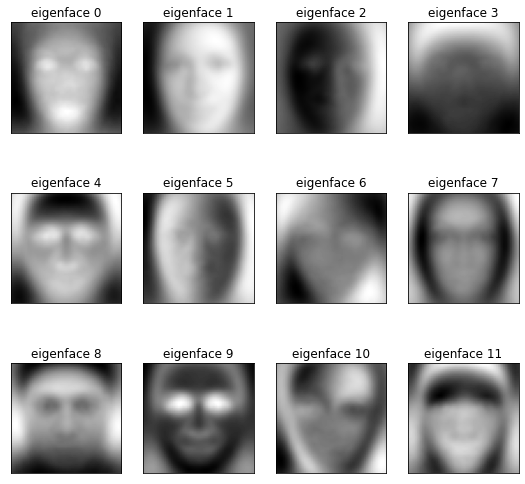

In [34]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 48, 48)
plt.show()

In [35]:
y_train_ = np.argmax(Y_train, axis=-1)

In [36]:
y_train_.shape

(28709,)

In [37]:
t0 = time()

In [38]:
param_grid = {'C': [1e3],
              'gamma': [0.001], }

In [39]:
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [40]:
clf = clf.fit(X_train_pca[:5000], y_train_[:5000])

In [41]:
print("done in %0.3fs" % (time() - t0))

done in 64.482s


In [42]:
print(clf.best_estimator_)

SVC(C=1000.0, class_weight='balanced', gamma=0.001)


In [43]:
t0 = time()

In [44]:
y_pred_public= clf.predict(X_val_pca_public)

In [45]:
y_pred_private= clf.predict(X_val_pca_private)

In [46]:
print("done in %0.3fs" % (time() - t0))

done in 5.127s


In [47]:
y_val_public = np.argmax(Y_test_public, axis=-1)

In [48]:
y_val_private = np.argmax(Y_test_private, axis=-1)

In [49]:
print(classification_report(y_val_public, y_pred_public))

              precision    recall  f1-score   support

           0       0.22      0.33      0.26       467
           1       0.20      0.14      0.16        56
           2       0.20      0.21      0.21       496
           3       0.54      0.53      0.54       895
           4       0.32      0.26      0.29       653
           5       0.52      0.44      0.47       415
           6       0.35      0.31      0.33       607

    accuracy                           0.36      3589
   macro avg       0.33      0.32      0.32      3589
weighted avg       0.37      0.36      0.36      3589



[[155   4  84  92  64  15  53]
 [ 15   8  11   7   9   0   6]
 [107   6 105  84  72  46  76]
 [128   9  82 474  92  25  85]
 [138  10  98 110 170  37  90]
 [ 48   1  73  29  39 181  44]
 [127   3  74  80  90  45 188]]


[Text(0.5, 61.5, 'Predicted label'), Text(61.5, 0.5, 'True label')]

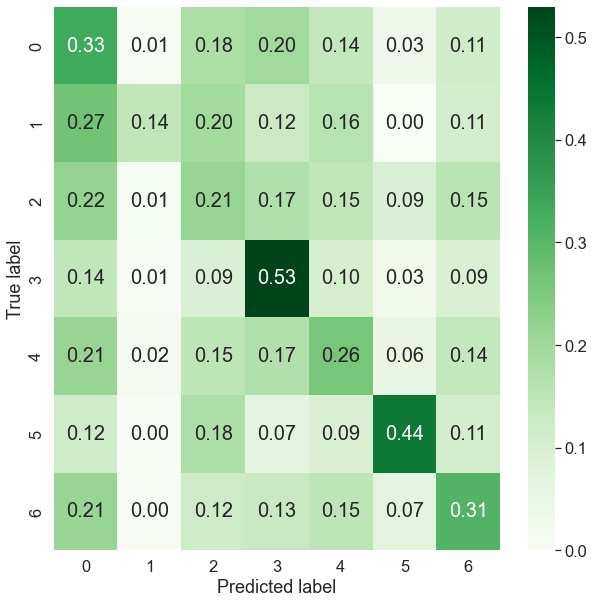

In [65]:
print(confusion_matrix(y_val_public, y_pred_public, labels=range(num_classes)))
from sklearn.metrics import confusion_matrix
import seaborn as sns
n_classes = Y_test_public.shape[1]
labels=range(n_classes)

cm = confusion_matrix(y_val_public, y_pred_public)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                 cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                 fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

              precision    recall  f1-score   support

           0       0.24      0.30      0.26       491
           1       0.24      0.15      0.18        55
           2       0.26      0.26      0.26       528
           3       0.54      0.53      0.53       879
           4       0.26      0.26      0.26       594
           5       0.47      0.41      0.44       416
           6       0.37      0.35      0.36       626

    accuracy                           0.36      3589
   macro avg       0.34      0.32      0.33      3589
weighted avg       0.37      0.36      0.36      3589



[Text(0.5, 61.5, 'Predicted label'), Text(61.5, 0.5, 'True label')]

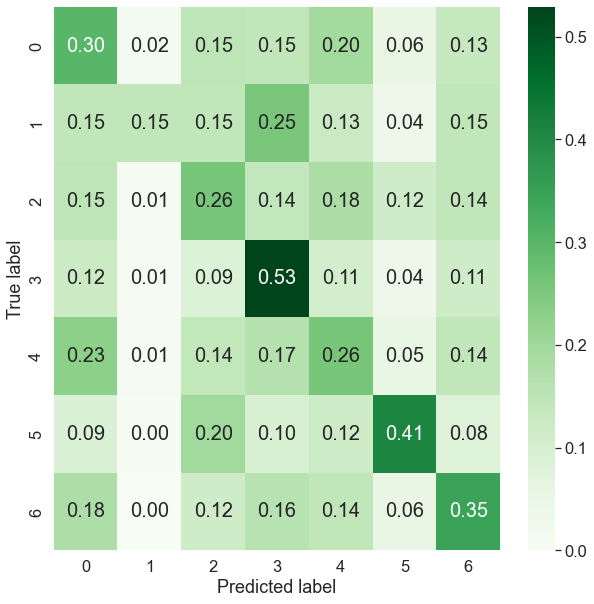

In [62]:
print(classification_report(y_val_private, y_pred_private))
from sklearn.metrics import confusion_matrix
import seaborn as sns
n_classes = Y_train.shape[1]
labels=range(n_classes)

cm = confusion_matrix(y_val_private, y_pred_private)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                 cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                 fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

In [52]:
print(confusion_matrix(y_val_private, y_pred_private, labels=range(num_classes)))

[[148   8  73  72  96  28  66]
 [  8   8   8  14   7   2   8]
 [ 78   4 137  74  96  63  76]
 [108   6  75 465  94  31 100]
 [136   4  84  99 154  32  85]
 [ 37   2  82  40  50 171  34]
 [111   1  72 100  90  35 217]]


In [57]:
accuracy = accuracy_score(y_val_private, y_pred_private)*100
print(accuracy)

36.22178879910838
